https://doi.org/10.1038/s41597-021-01046-y

In [1]:
import importlib

# List of libraries to check
libraries = [
    'numpy',
    'matplotlib',
    'scipy',
    'torch',
    'torchdiffeq',
    'torchsummary',
    'minepy',
    'pyrqa',
    'pyts',
    'MFDFA',
    'pyinform',
    'graphviz',
    'fa2',
    'networkx'
]

for lib in libraries:
    try:
        module = importlib.import_module(lib)
        version = getattr(module, '__version__', 'Unknown version')
        print(f'{lib}: {version}')
    except ImportError:
        print(f'{lib} is not installed.')

numpy: 1.24.3
matplotlib: 3.7.0
scipy: 1.10.1
torch: 2.0.1+cu117
torchdiffeq: 0.2.3
torchsummary: Unknown version
minepy: b'1.2.6'
pyrqa: Unknown version
pyts: 0.12.0
MFDFA: 0.4.3
pyinform: Unknown version
graphviz: 0.20.1
fa2 is not installed.
networkx: 3.0


    Data include within participant application of nine High-Definition tES (HD-tES) types, targeting three cortical regions (frontal, motor, parietal) with three stimulation waveforms (DC, 5 Hz, 30 Hz); more than 783 total stimulation trials over 62 sessions with EEG, physiological (ECG, EOG), and continuous behavioral vigilance/alertness metrics. Experiment 1 and 2 consisted of participants performing a continuous vigilance/alertness task over three 70-minute and two 70.5-minute sessions, respectively. Demographic data were collected, as well as self-reported wellness questionnaires before and after each session. Participants received all 9 stimulation types in Experiment 1, with each session including three stimulation types, with 4 trials per type. Participants received 2 stimulation types in Experiment 2, with 20 trials of a given stimulation type per session. Within-participant reliability was tested by repeating select sessions. This unique dataset supports a range of hypothesis testing including interactions of tDCS/tACS location and frequency, brain-state, physiology, fatigue, and cognitive performance.

    participants maintained a ball at the center of the screen and were periodically stimulated (with low-intensity noninvasive brain stimulation) for 30 secs with combinations of 9 stimulation montages

    DSamp

    triggers <- These are all the labeled EEG/Stimulation start/stop triggers
    EEGdata <- Contains the downsampled EEG/ECG/EOG voltage data dims: 35 channelss X ~4E6 samples
    fs <- The downsampled sampling frequency of the data : 1000 Hz
    fsOld <- The original sampling frequency of the data
    time <- Time vector for the data. Should be 1 X ~4E6
    label <- Contains the channel label information. BIP1= ECG, BIP2=EOG, RESP1= N/A
    nchan <- The number of channels in the data
    rate <- Redundant to fs, sampling rate of data
    npt <- Number of data points ~4E6
    Subj <- Subject and session that data belong to. I.e. 0302 - Subject 03 session 03
    ptrackerPerf <- The CTT data deviation/ the behavioral data
    ptrackerTime <- Time vector for the CTT data
    ptrackerfs <- The sampling frequency for the CTT data 100 Hz.

In [2]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
import pyqtgraph as pg
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from attractors import Attractor
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from antropy import higuchi_fd

/home/vincent/miniconda3/lib/python3.10/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


<div style="font-size: 13px; font-family: 'Times New Roman', Times, serif; background-color: #181818; color: #D0D0D0; padding: 20px; border-radius: 8px; margin: 10px; display: flex; flex-wrap: nowrap; justify-content: space-between;">
    <!-- Column 1 -->
    <div style="flex: 1; margin-right: 10px;">
        <h2>Introduction</h2>
    <p>This section elucidates the key steps taken to load and preprocess the Electroencephalogram (EEG) data and accompanying stimulation data, setting the stage for subsequent modeling and analyses. The EEG data are stored in MATLAB's .mat file structure, while the stimulation data are housed in an Excel sheet.</p>
        <h2>Objectives</h2>
        <p style="text-indent: 40px;">Data Importation: Efficiently load EEG data and stimulation information into the Python environment.</p>
        <p style="text-indent: 40px;">Data Cleansing: Handle missing values in the stimulation dataset and remove extraneous header information.</p>
        <p style="text-indent: 40px;">Metadata Extraction: Delve into the loaded EEG data to segregate various elements like triggers, sampling frequencies, and labels.</p>
        <p style="text-indent: 40px;">Channel Filtration: Methodologically exclude channels that are irrelevant for the scope of our inquiry.</p>
        <h2>Mathematical Formulation</h2>
    <p>The loaded EEG data structure can be mathematically represented as a multi-dimensional set \( DSamp \) containing various elements.</p>
    \[ DSamp = \{ \text{Triggers, EEGdata, fs, fsOld, Time, Label, nChan, Rate, nPt, Subj, PtrackerPerf, PtrackerTime, PtrackerFs} \} \]
    <p>Here, each element serves a distinct purpose:</p>
    <ul>
        <li>Triggers: Trigger events encapsulated within the EEG data.</li>
        <li>EEGdata: The matrix containing the EEG signals.</li>
        <li>fs: The sampling frequency after the EEG data have been downsampled.</li>
        <li>fsOld: The original sampling frequency prior to downsampling.</li>
        <li>Time: The vector containing time points corresponding to EEG data.</li>
        <li>Label: The labels designating the EEG channels.</li>
        <li>nChan: The total number of EEG channels.</li>
        <li>Rate: A rate variable, the purpose of which requires additional context.</li>
        <li>nPt: The number of data points in each EEG channel.</li>
        <li>Subj: An identifier for the subject from whom the EEG data were collected.</li>
        <li>PtrackerPerf: Metrics pertaining to pointer tracker performance.</li>
        <li>PtrackerTime: Time metrics from the pointer tracker.</li>
        <li>PtrackerFs: Sampling frequency of the pointer tracker.</li>
    </ul>
    </div>
    <!-- Column 2 -->
    <div style="flex: 1; margin-left: 10px;">
    <h2>Data Cleansing and Imputation</h2>
    <p>The stimulation data potentially contain missing values specifically in the column designated 'Sub#'. The forward fill method is employed for imputing these missing values. Mathematically, this is equivalent to the function:</p>
    \[ f(x_i) = 
    \begin{cases} 
    x_{i-1} & \text{if } x_i \text{ is missing} \\
    x_i & \text{otherwise}
    \end{cases}
    \]
    <h2>Channel Filtration</h2>
    <p>The EEG data may contain channels that are not pertinent to the current analysis. Let \( L \) be the original set of channel labels and \( U \) be the set of unwanted channel labels. The set \( F \) of filtered channel labels is then: \( F = L - U \), where \( U = \{"BIP1","BIP2","RESP1"\} \).</p>
    <h2>Summary</h2>
    <p>This section provides a high-level mathematical and programmatical blueprint for the data loading and preprocessing steps that follow. Understanding the nuances of these steps is essential for replicability and further analyses, especially given the high dimensionality and complex structure of EEG data. We will leverage this cleaned and organized data in the subsequent steps for neural network modeling and interpretation.</p>
    <p>Now that the framework has been outlined, the next section of the notebook will contain the executable Python code that carries out these operations.</p>
   </div>
</div>

In [3]:
# Load data
data = loadmat('/home/vincent/AAA_projects/MVCS/Neuroscience/downsampled/EEG_DS_Struct_0101.mat')
stim_data = pd.read_excel('/home/vincent/AAA_projects/MVCS/Neuroscience/EEG-tES-Chaos-Neural-Net/stim_data.xlsx')

# Fill null values in 'Sub#' column
stim_data['Sub#'].fillna(method='ffill', inplace=True)

# Drop the first row
stim_data = stim_data.drop(0)

DSamp = data['DSamp']

# Get data parameters
triggers = DSamp[0][0][0]
EEGdata = DSamp[0][0][1]
fs = DSamp[0][0][2][0][0]
fsOld = DSamp[0][0][3][0][0]
time = DSamp[0][0][4][0]
label = DSamp[0][0][5]
nchan = DSamp[0][0][6][0][0]
rate = DSamp[0][0][7][0][0]
npt = DSamp[0][0][8][0][0]
Subj = DSamp[0][0][9][0]
ptrackerPerf = DSamp[0][0][10]
ptrackerTime = DSamp[0][0][11]
ptrackerfs = DSamp[0][0][12][0][0]

# List of unwanted channel names
unwanted_channels = ['BIP1', 'BIP2', 'RESP1']

# Filter out unwanted channels from the label data
filtered_label = [ch for ch in label if ch[0][0] not in unwanted_channels]

# Convert the filtered list back to numpy array and replace the original label
label = np.array(filtered_label, dtype=object)

print(triggers, EEGdata, label, stim_data)

[[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64))
  (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[805.571]]), array([[805572]], dtype=int32), array(['0032'], dtyp

In [4]:
shape_of_data = DSamp[0][0][1].shape
print(shape_of_data)

(35, 4227788)


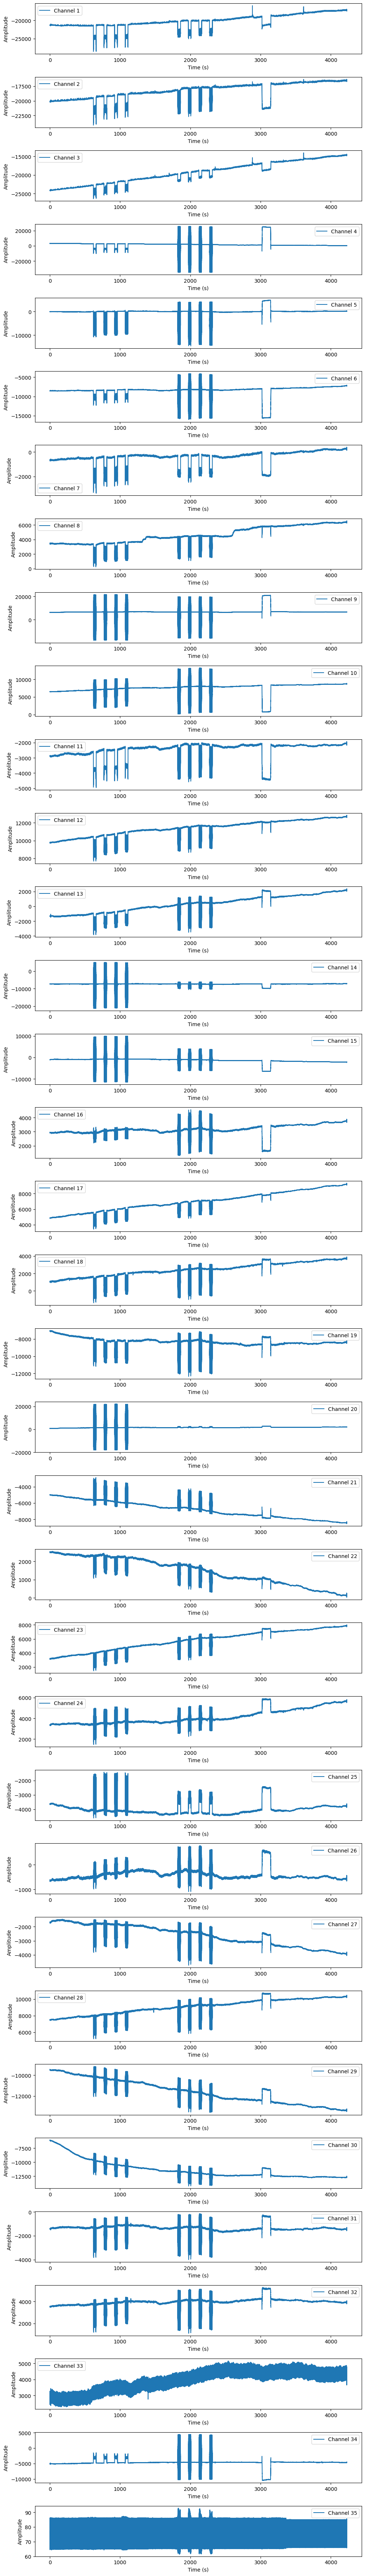

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that EEGdata and time are numpy arrays
EEGdata = np.array(EEGdata)
time = np.array(time)

# Checking the number of channels
nchan = EEGdata.shape[0]

# Creating a figure with nchan subplots, one for each channel
fig, axs = plt.subplots(nchan, 1)

# Setting the figure size
fig.set_size_inches(10, 2*nchan)

# Loop over all the channels
for i in range(nchan):
    axs[i].plot(time, EEGdata[i], label='Channel '+str(i+1))  # Use the entire 'time' array
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()


# Automatically adjust subplot params so the subplot(s) fits into the figure area
plt.tight_layout()

# Display the plot
plt.show()

<div style="font-size: 13px; font-family: 'Times New Roman', Times, serif; background-color: #181818; color: #D0D0D0; padding: 20px; border-radius: 8px; margin: 10px; display: flex; flex-wrap: nowrap; justify-content: space-between;">
    <!-- Column 1 -->
    <div style="flex: 1; margin-right: 10px;">
        <h2>Introduction</h2>
        <p>This section is dedicated to elucidating the methodology employed for phase space reconstruction of time-series EEG data using a mathematical technique known as delay embedding. This is a critical step for transforming time-sequential data into a spatial construct, facilitating advanced analysis techniques such as attractor analysis, Lyapunov exponent computation, and surrogate data testing.</p>
        <h2>Objectives</h2>
        <ul>
            <li>Delay Embedding: Perform a formal delay embedding transformation on a selected EEG channel.</li>
            <li>Dimensionality Transformation: Transform the one-dimensional time-series EEG data into a higher-dimensional phase space.</li>
            <li>Visual Exploration: Generate a 3D phase space plot for the embedded data.</li>
        </ul>
        <h2>Mathematical Foundations</h2>
        <h3>Delay Embedding Function</h3>
        <p>Let \( x(t) \) be the time-series EEG data, where \( t=1,2,\ldots,N \). The delay embedding function \( \phi \) maps \( x(t) \) into \( R^m \), where \( m \) is the embedding dimension, and \( \tau \) is the delay parameter.</p>
        \[ \phi : x(t) \mapsto X(t) = [ x(t), x(t-\tau), x(t-2\tau), \ldots, x(t-(m-1)\tau) ] \]
        <p>The function \( \phi \) is applied to create an \( m \)-dimensional vector \( X(t) \) from the original time series \( x(t) \).</p>
    </div>
    <!-- Column 2 -->
    <div style="flex: 1; margin-left: 10px;">
        <h2>Dimensionality and Delay</h2>
        <p>In our application, the embedding dimension \( m \) is set to 3, and the delay \( \tau \) is set to 1. This choice of \( m \) and \( \tau \) can be further refined based on specific requirements such as false nearest neighbor analyses or Lyapunov exponent estimation, but for the initial exploration, these values are sufficient.</p>
        \[ m=3,\tau=1 \]
        <h2>Phase Space Reconstruction</h2>
        <p>The phase space \( P \) is constructed by applying \( \phi \) on \( x(t) \) for each \( t \) in the domain of \( x \):</p>
        \[ P = \{ X(t) \mid t = 1, \ldots, N - (m-1)\tau \} \]
        <h2>3D Visualization</h2>
        <p>The phase space \( P \) is visualized in a 3D plot, where the axes represent the components \( x(t) \), \( x(t-\tau) \), and \( x(t-2\tau) \) respectively.</p>
        <h2>Summary</h2>
        <p>Phase space reconstruction via delay embedding serves as a key element in our pipeline, acting as a bridge between raw EEG data and advanced nonlinear dynamic analyses. With a properly reconstructed phase space, we are better positioned to explore properties like chaotic behavior and temporal correlations in EEG signals, critical for applications such as neural decoding or understanding brain-machine interfaces.</p>
        <p>In the next section of this notebook, we implement the delay embedding process, followed by a 3D visualization of the resultant phase space. The function delay_embedding will encapsulate the mathematical foundation described herein, while visualization techniques will be used to facilitate an intuitive understanding of the reconstructed space.</p>
    </div>
</div>

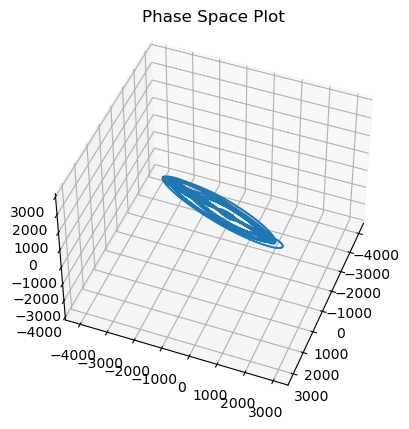

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function for delay embedding
def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Choose the first channel of your EEG data
channel_data = EEGdata[0, :]

# Perform delay embedding with embedding dimension 3 and delay 1
embedded_channel_data = delay_embedding(channel_data, emb_dim=3, delay=1)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Change viewing angle
ax.view_init(elev=45, azim=21)

ax.plot(embedded_channel_data[:, 0], embedded_channel_data[:, 1], embedded_channel_data[:, 2])
plt.title('Phase Space Plot')
plt.show()

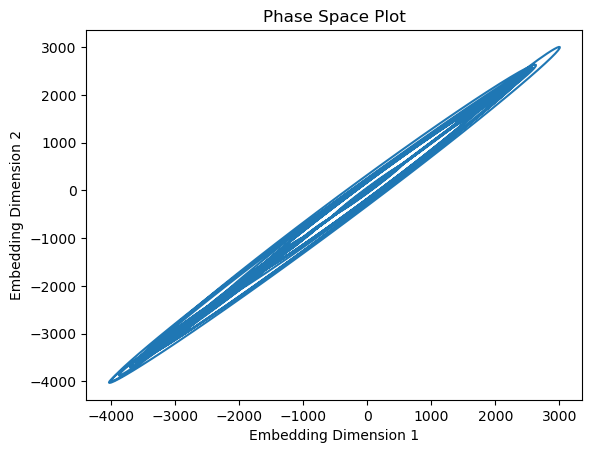

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function for delay embedding
def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Choose the first channel of your EEG data
channel_data = EEGdata[0, :]

# Perform delay embedding with embedding dimension 2 and delay 1
embedded_channel_data = delay_embedding(channel_data, emb_dim=2, delay=1)

# Create 2D plot
plt.figure()
plt.plot(embedded_channel_data[:, 0], embedded_channel_data[:, 1])
plt.title('Phase Space Plot')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()